<a href="https://colab.research.google.com/github/vishal-burman/PyTorch-Architectures/blob/master/modeling_Word2Vec/test_sample_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install datasets
! git clone https://github.com/vishal-burman/PyTorch-Architectures.git

In [1]:
%cd PyTorch-Architectures/modeling_Word2Vec/

/content/PyTorch-Architectures/modeling_Word2Vec


In [14]:
import time
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from model import Word2Vec

dataset = load_dataset('quora')

Using custom data configuration default
Reusing dataset quora (/root/.cache/huggingface/datasets/quora/default/0.0.0/2be517cf0ac6de94b77a103a36b141347a13f40637fbebaccb56ddbe397876be)


In [3]:
sentences = []
for sample in dataset['train']:
  if len(sentences) == 1000:
    break
  sentences.append(sample['questions']['text'][0].lower())

word_sequence = ' '.join(sentences).split()
word_list = ' '.join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
print('Vocabulary Size: ', len(word_list))

Vocabulary Size:  3395


In [4]:
skip_grams = []
for i in range(1, len(word_sequence) - 1):
  target = word_dict[word_sequence[i]]
  context = [word_dict[word_sequence[i-1]], word_dict[word_sequence[i+1]]]
  for w in context:
    skip_grams.append([target, w])

random.shuffle(skip_grams)
print('Number of Skip-Grams: ', len(skip_grams))

Number of Skip-Grams:  21350


In [5]:
split = 90 * len(skip_grams) // 100
train_skip_grams = skip_grams[:split]
valid_skip_grams = skip_grams[split:]
print('Train Skip-Grams: ', len(train_skip_grams))
print('Valid Skip-Grams: ', len(valid_skip_grams))

Train Skip-Grams:  19215
Valid Skip-Grams:  2135


In [6]:
class CustomDataset(Dataset):
  def __init__(self, skip_grams, voc_size):
    self.skip_grams = skip_grams
    self.voc_size = voc_size
    self.eye = torch.eye(self.voc_size)
  
  def __len__(self):
    return len(self.skip_grams)
  
  def __getitem__(self, idx):
    random_inputs = self.eye[skip_grams[idx][0]]
    random_labels = torch.tensor(skip_grams[idx][1])
    return random_inputs, random_labels

In [7]:
# Hyperparameters
VOCAB_SIZE = len(word_list)
EMB_SIZE = 2
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 10

In [8]:
train_dataset = CustomDataset(train_skip_grams, voc_size=VOCAB_SIZE)
valid_dataset = CustomDataset(valid_skip_grams, voc_size=VOCAB_SIZE)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Word2Vec(vocab_size=VOCAB_SIZE, emb_size=EMB_SIZE)
model.to(device)

Word2Vec(
  (W): Linear(in_features=3395, out_features=2, bias=False)
  (WT): Linear(in_features=2, out_features=3395, bias=False)
)

In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Length of Train Loader: ", len(train_loader))
print('Length of Valid Loader: ', len(valid_loader))

# Sanity checks
for inputs, targets in train_loader:
  assert inputs.dim() == 2
  assert inputs.size(1) == VOCAB_SIZE
  assert targets.size(0) == BATCH_SIZE
  break

Length of Train Loader:  601
Length of Valid Loader:  67


In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [12]:
def compute_loss(model, data_loader, device):
  loss_list = []
  with torch.set_grad_enabled(False):
    for (inputs, targets) in data_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)
      logits = model(inputs)

      loss = F.cross_entropy(logits, targets)
      loss_list.append(loss.item())
  return torch.tensor(loss_list).mean()

start_time = time.time()
for epoch in range(EPOCHS):
  model.train()
  for batch_idx, (inputs, targets) in enumerate(train_loader):
    inputs = inputs.to(device)
    targets = targets.to(device)
    logits = model(inputs)
    loss = F.cross_entropy(logits, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # LOGGING
    if batch_idx % 200 == 0:
      print('Epoch: %04d/%04d || Batch: %04d/%04d || Loss: %.2f' % (epoch+1, EPOCHS, batch_idx, len(train_loader), loss.item()))
  
  model.eval()
  with torch.set_grad_enabled(False):
    train_loss = compute_loss(model, train_loader, device)
    valid_loss = compute_loss(model, valid_loader, device)
    print('Train Loss: %.2f' % (train_loss.item()))
    print('Valid Loss: %.2f' % (valid_loss.item()))
  epoch_elapsed_time = (time.time() - start_time) / 60
  print('Epoch elapsed time: %.2f min' % (epoch_elapsed_time))
total_training_time = (time.time() - start_time) / 60
print('Total training time: %.2f min' % (total_training_time))

Epoch: 0001/0010 || Batch: 0000/0601 || Loss: 8.13
Epoch: 0001/0010 || Batch: 0200/0601 || Loss: 8.12
Epoch: 0001/0010 || Batch: 0400/0601 || Loss: 8.13
Epoch: 0001/0010 || Batch: 0600/0601 || Loss: 8.11
Train Loss: 8.09
Valid Loss: 8.09
Epoch elapsed time: 0.02 min
Epoch: 0002/0010 || Batch: 0000/0601 || Loss: 8.12
Epoch: 0002/0010 || Batch: 0200/0601 || Loss: 8.06
Epoch: 0002/0010 || Batch: 0400/0601 || Loss: 8.02
Epoch: 0002/0010 || Batch: 0600/0601 || Loss: 7.95
Train Loss: 7.88
Valid Loss: 7.87
Epoch elapsed time: 0.05 min
Epoch: 0003/0010 || Batch: 0000/0601 || Loss: 7.91
Epoch: 0003/0010 || Batch: 0200/0601 || Loss: 7.81
Epoch: 0003/0010 || Batch: 0400/0601 || Loss: 7.76
Epoch: 0003/0010 || Batch: 0600/0601 || Loss: 7.92
Train Loss: 7.57
Valid Loss: 7.55
Epoch elapsed time: 0.07 min
Epoch: 0004/0010 || Batch: 0000/0601 || Loss: 7.54
Epoch: 0004/0010 || Batch: 0200/0601 || Loss: 7.38
Epoch: 0004/0010 || Batch: 0400/0601 || Loss: 7.47
Epoch: 0004/0010 || Batch: 0600/0601 || Loss: 

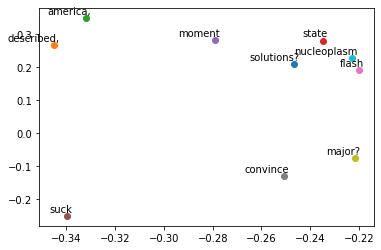

In [17]:
model.eval()
for i, label in enumerate(word_list[:10]):
  with torch.set_grad_enabled(False):
    W, WT = model.parameters()
  x, y = W[0][i].item(), W[1][i].item()
  plt.scatter(x, y)
  plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()